In [11]:
import numpy as np
import pickle  
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import load_model
import netron 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score,roc_curve,roc_auc_score
from confusion_matrix_pretty_print import plot_confusion_matrix_from_data
from xai_utils import RISE_1D, grad_cam
import shap

tensorflow.compat.v1.disable_v2_behavior()

# Task 1

In [12]:
DATA_PATH = './data/MNIST1D.pkl'
MODEL_PATH = "./data/models/MNIST1D.h5"

## Load the model and data

In [13]:

#visialize the model
netron.start(MODEL_PATH)

#load model
model = tensorflow.keras.models.load_model(MODEL_PATH)

#load data
images = pickle.load(open(DATA_PATH, "rb"))

Serving './data/models/MNIST1D.h5' at http://localhost:24683


## Data visualization

In [14]:
x_img=images['x'] #(4000, 40)
x_test=images['x_test'] #(1000, 40)
y_lable=images['y'] #(4000,)
y_test=images['y_test'] #(1000,)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


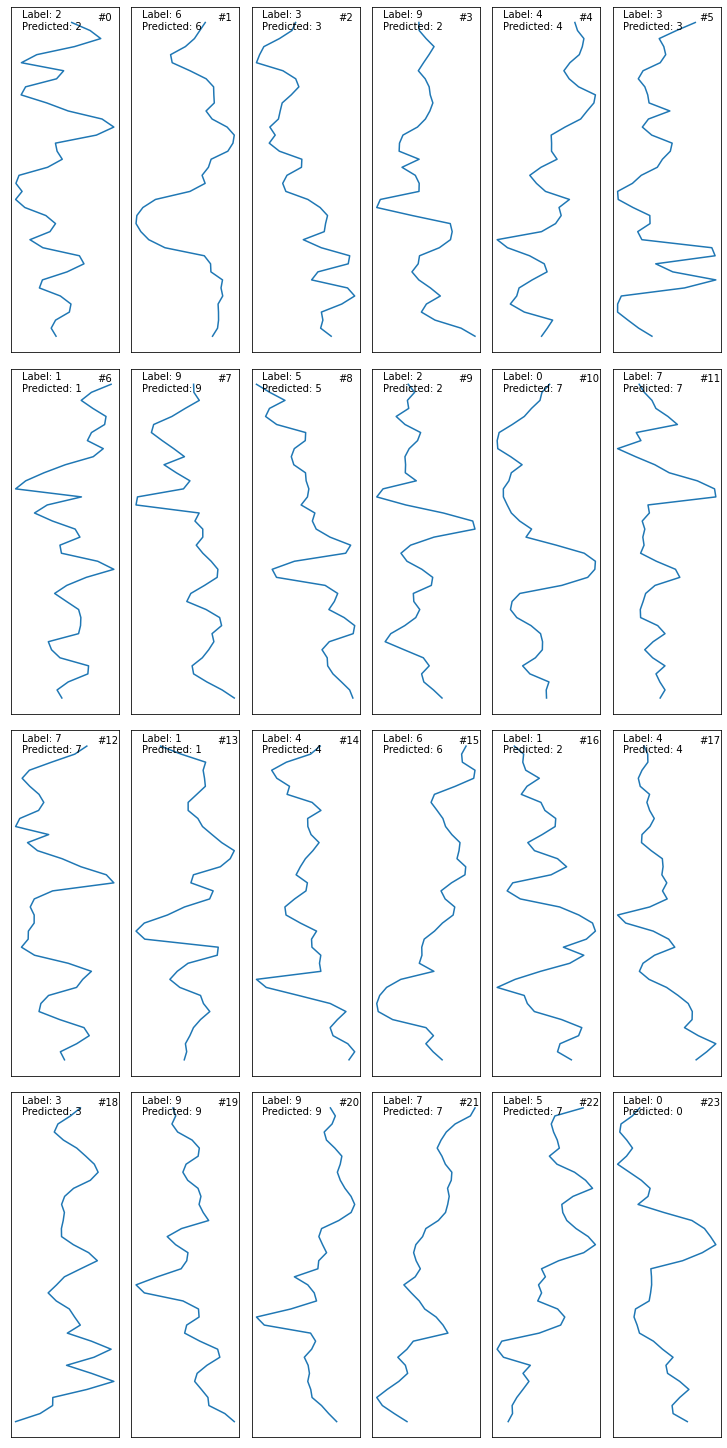

In [15]:
widths=[2,2,2,2,2,2]
heights=[3,3,3,3]
x = np.linspace(0,1, 40)

gs_kw = dict(width_ratios=widths, height_ratios=heights)
fig6, f6_axes = plt.subplots(ncols=6, nrows=4, constrained_layout=True,
                             gridspec_kw=gs_kw,figsize=(10, 20))
count=0
for r, row in enumerate(f6_axes):
    for c, ax in enumerate(row):
        
        temp=np.expand_dims(x_test[count,],axis=(1))
        x_test_dim=np.expand_dims(temp,axis=0)

        result=model.predict(x_test_dim)
        ax.plot(x_test[count,],x)
        
        label='Label: {}\nPredicted: {}'.format(y_test[count],np.argmax(result[0]))
        clabel='#{}'.format(count)
        ax.annotate(label,(0.1, 0.96), xycoords='axes fraction', va='center')
        ax.annotate(clabel,(0.80,0.97),xycoords='axes fraction', va='center')
        ax.set_xticks([]); ax.set_yticks([])
        count=count+1
        

## a.Overall classification accuracy on the test set

In [16]:
preds = model.predict(np.expand_dims(x_test,axis=2))
soft_preds = preds.copy()
preds = np.argmax(preds,axis=1)

In [17]:
print(f'Accuracy: {accuracy_score(y_test,preds)*100} %')

Accuracy: 87.7 %


## b.Class-wise classification accuracy for all classes

In [18]:
#accuracy_score(predictions,true)

In [19]:
classes = np.unique(y_test)


for cl in classes: #itterate over each class
    temp_pred = preds[y_test==cl]#select pridictions by class
    temp_y = y_test[y_test==cl]  #tue stuff

    print(f'Accuracy: {np.round(accuracy_score(temp_y,temp_pred)*100,1)} %, class: {cl}')

Accuracy: 98.0 %, class: 0
Accuracy: 80.8 %, class: 1
Accuracy: 88.8 %, class: 2
Accuracy: 94.3 %, class: 3
Accuracy: 84.9 %, class: 4
Accuracy: 81.6 %, class: 5
Accuracy: 91.9 %, class: 6
Accuracy: 86.5 %, class: 7
Accuracy: 91.8 %, class: 8
Accuracy: 78.4 %, class: 9


## c.ROC-AUC curves

ROC-AUC score: 100.0 %, class: 0
ROC-AUC score: 99.0 %, class: 1
ROC-AUC score: 98.2 %, class: 2
ROC-AUC score: 100.0 %, class: 3
ROC-AUC score: 98.8 %, class: 4
ROC-AUC score: 98.5 %, class: 5
ROC-AUC score: 99.8 %, class: 6
ROC-AUC score: 99.2 %, class: 7
ROC-AUC score: 99.7 %, class: 8
ROC-AUC score: 97.2 %, class: 9


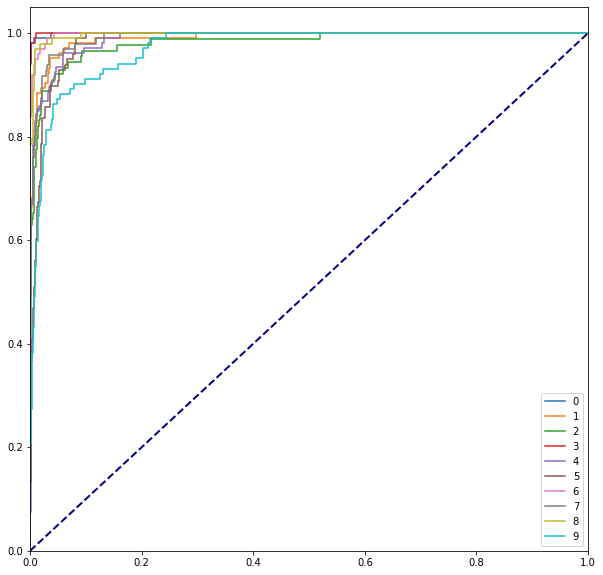

In [20]:
classes = np.unique(y_test)


fig = plt.figure(figsize=(10,10))

y_test_oh = np.eye(10)[y_test]

for cl in classes:
    temp_pred = soft_preds[:,cl]
    temp_y = y_test_oh[:,cl]
    
    
    curve = roc_curve(temp_y,temp_pred)
    
    print(f'ROC-AUC score: {np.round(roc_auc_score(temp_y,temp_pred)*100,1)} %, class: {cl}')
    
    
    plt.plot(curve[0],curve[1])

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.legend(classes.astype(str).tolist())
    

## d. Confusion Matrix

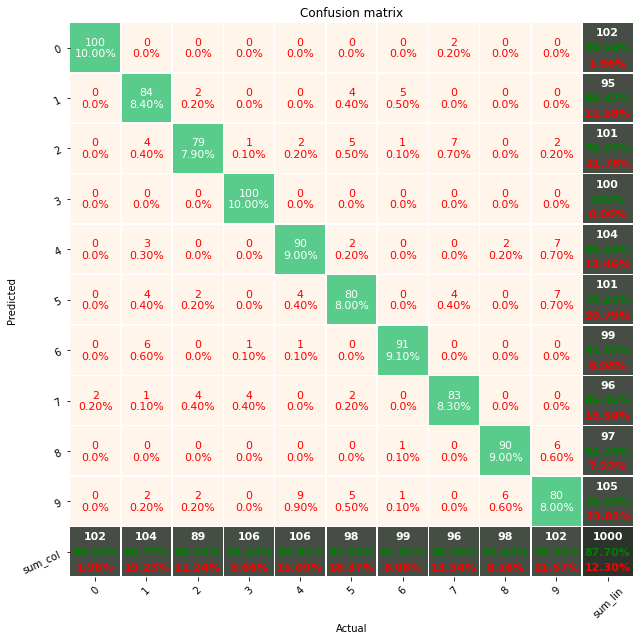

In [21]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

plot_confusion_matrix_from_data(y_test, preds,figsize=[30,30],columns=['0','1','2','3','4','5','6','7','8','9'])

## d. Qualitative examples

In [22]:
error = np.sum(np.abs(soft_preds - np.eye(10)[y_test]),axis=1)

arr1inds = error.argsort() #return indexies
x_test_sorted = x_test[arr1inds[::-1],:] #reverse 
y_test_sorted = y_test[arr1inds[::-1]]
soft_preds_sorted = soft_preds[arr1inds[::-1]]

N_SAMPLES = 5

### Best performance

In [23]:
x_best = x_test_sorted[-N_SAMPLES:,:]
y_best = y_test_sorted[-N_SAMPLES:]
soft_pred_best = soft_preds_sorted[-N_SAMPLES:,:]

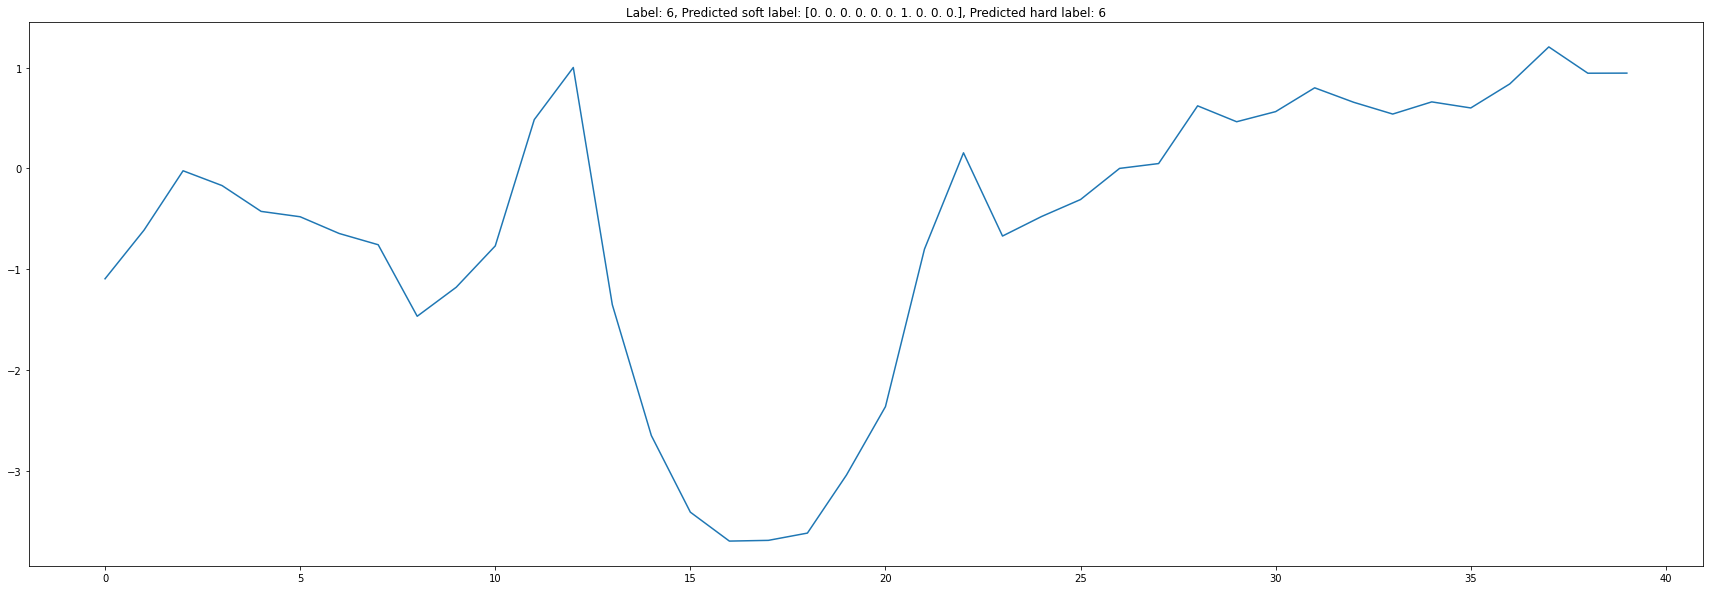

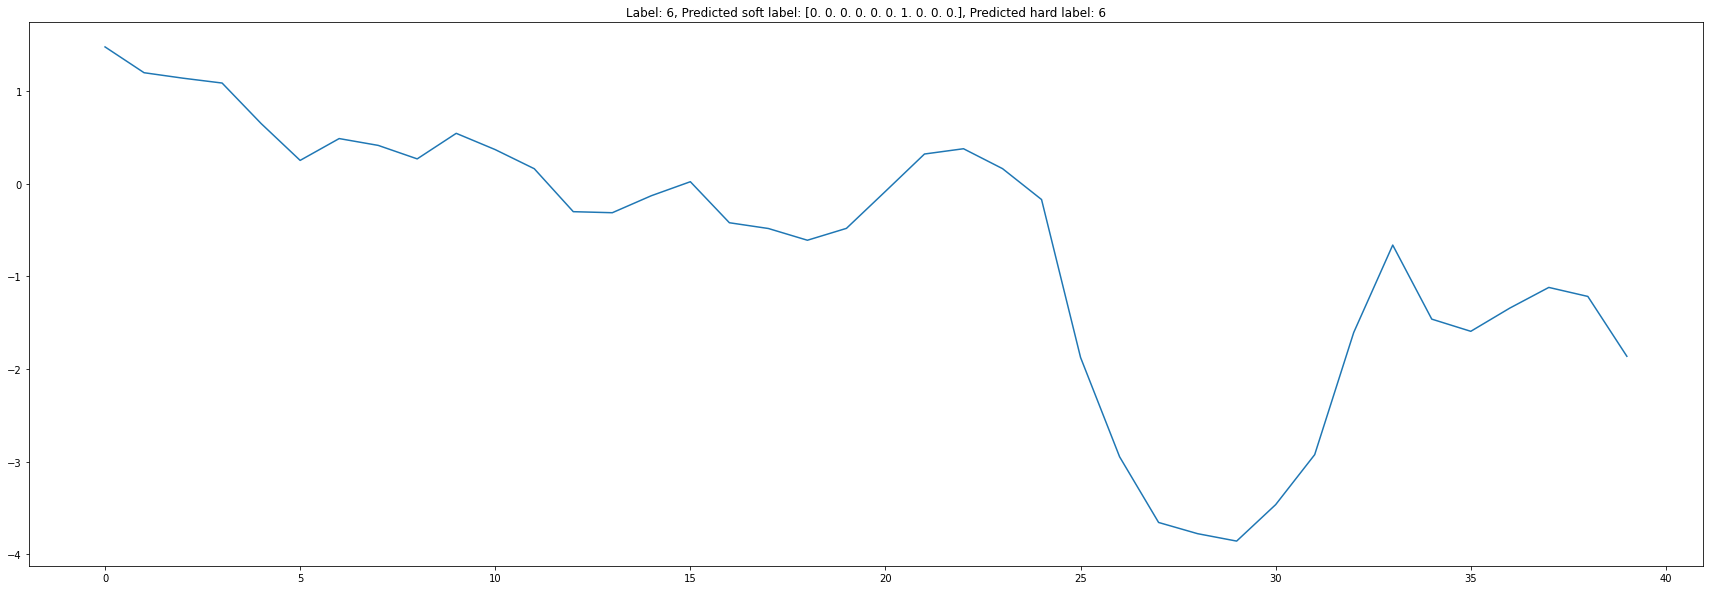

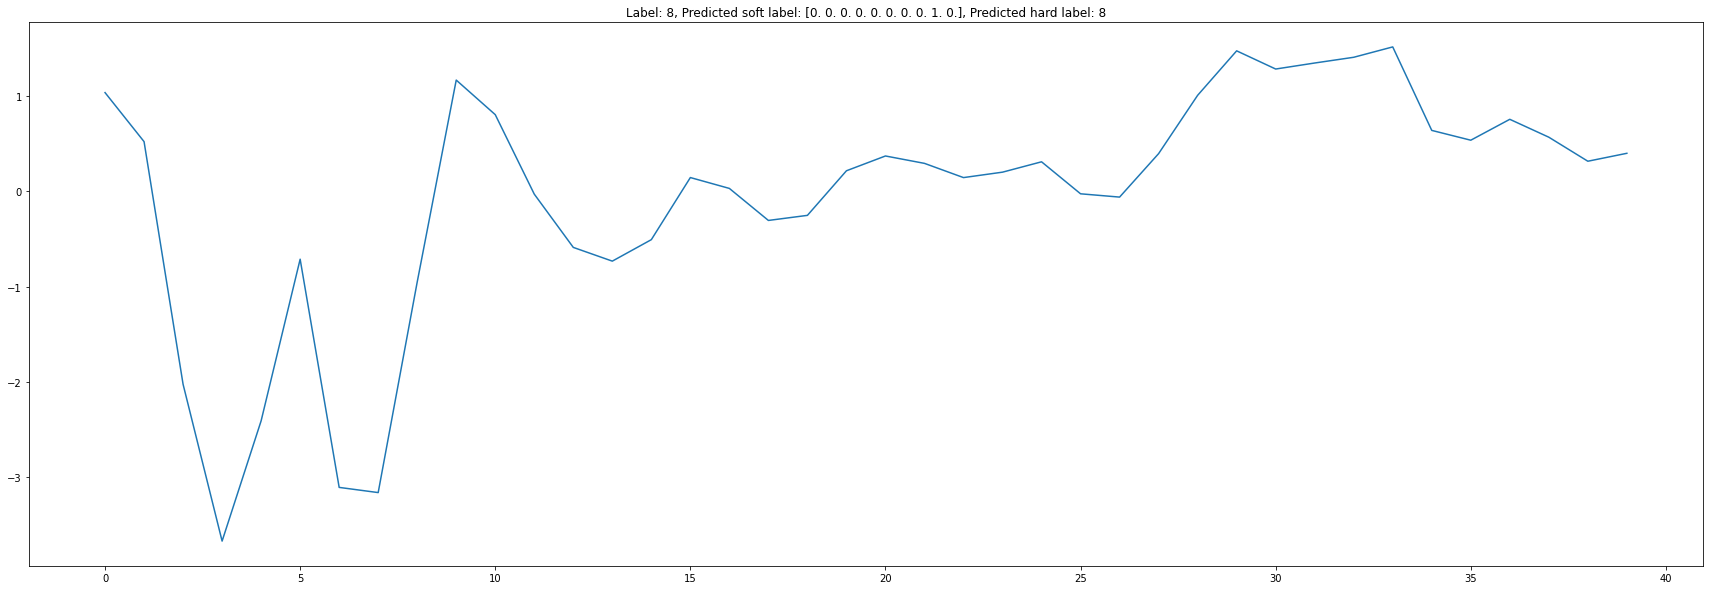

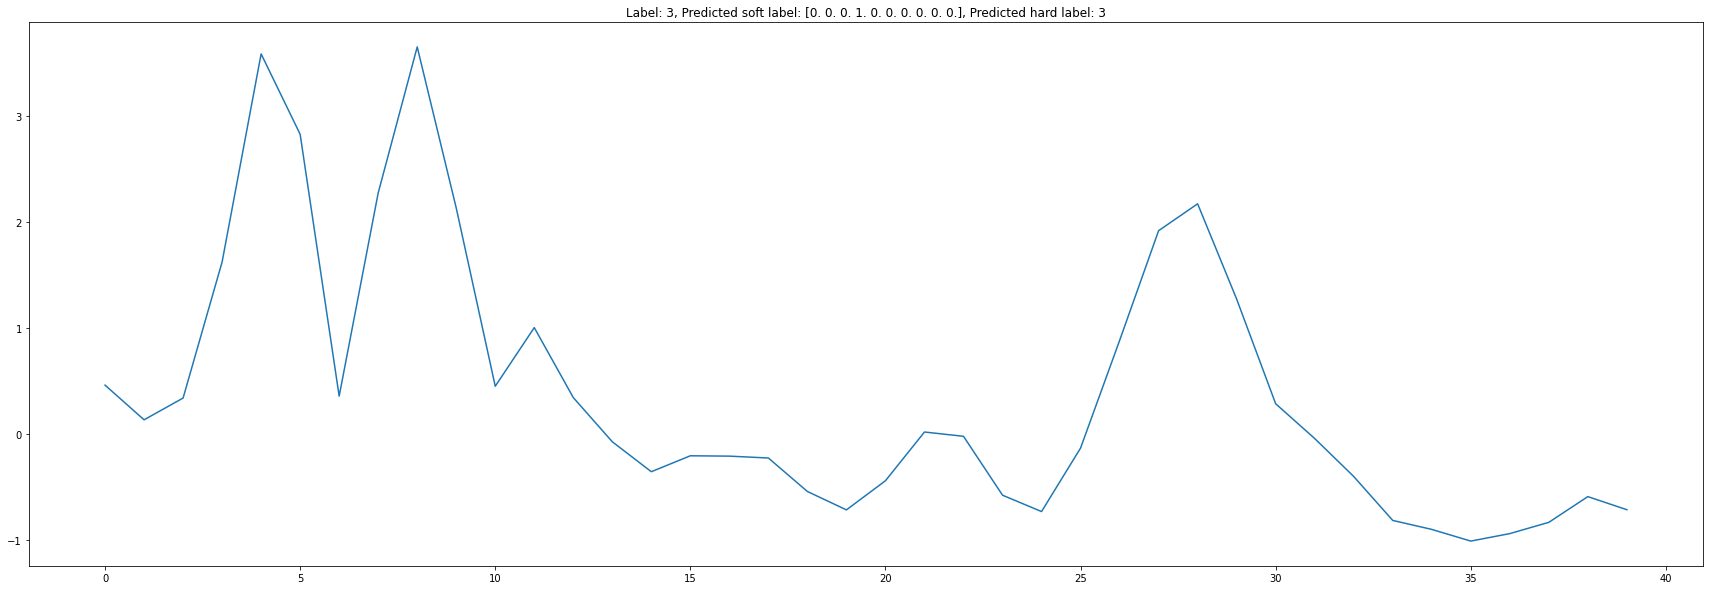

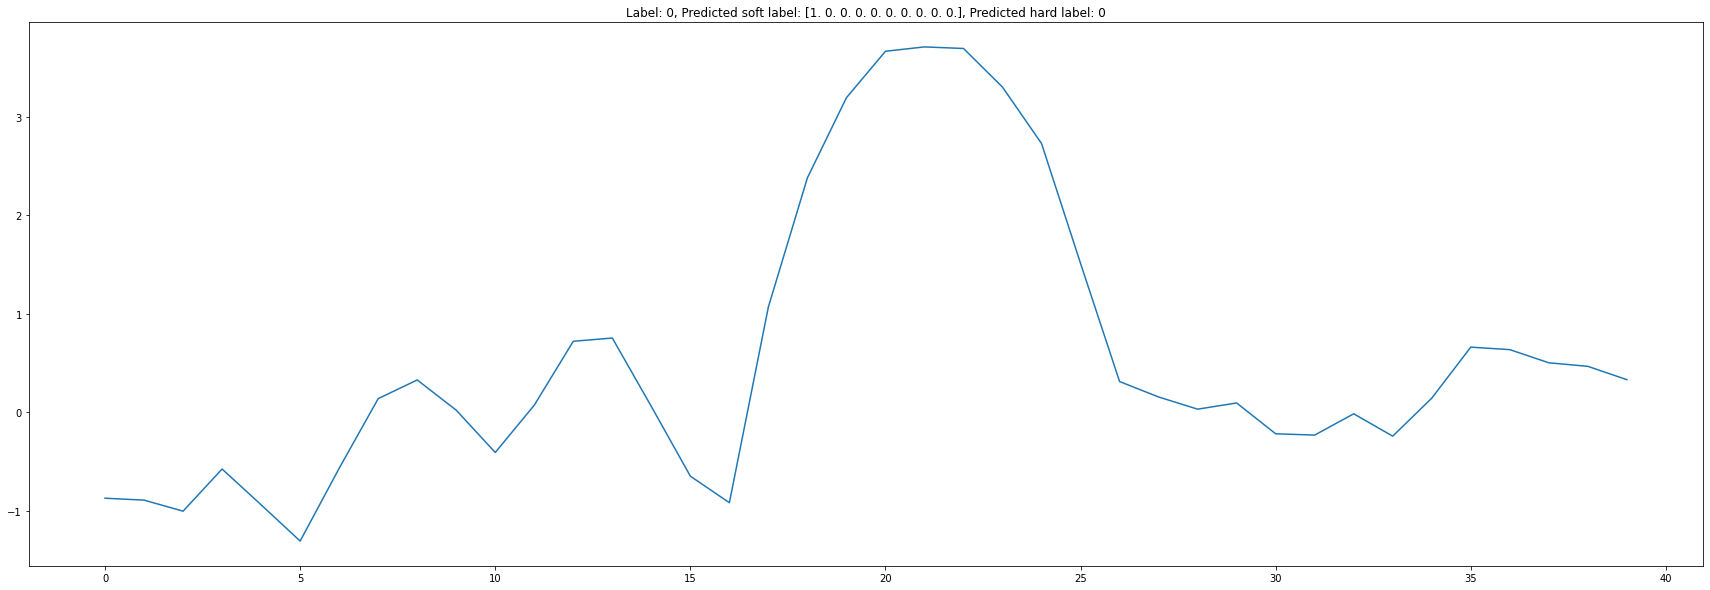

In [24]:
for i in range(x_best.shape[0]):
    fig = plt.figure(figsize=(30,10))
    plt.plot(x_best[i])
    plt.title(f'Label: {y_best[i]}, Predicted soft label: {np.round(soft_pred_best[i,:],2)}, Predicted hard label: {np.argmax(soft_pred_best[i,:])}')
    
    

### Worst performance

In [25]:
x_worst = x_test[:N_SAMPLES,:]
y_worst = y_test[:N_SAMPLES]
soft_pred_worst = soft_preds_sorted[:N_SAMPLES,:]

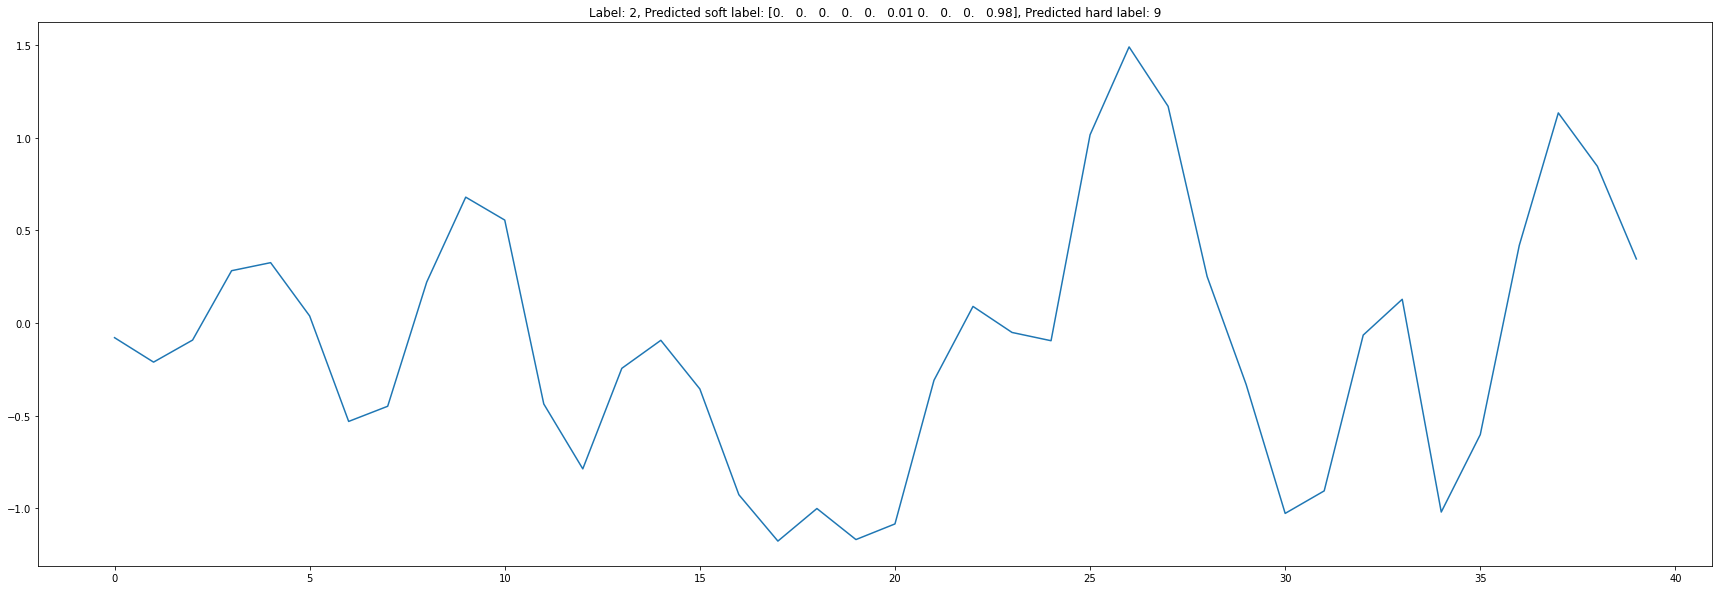

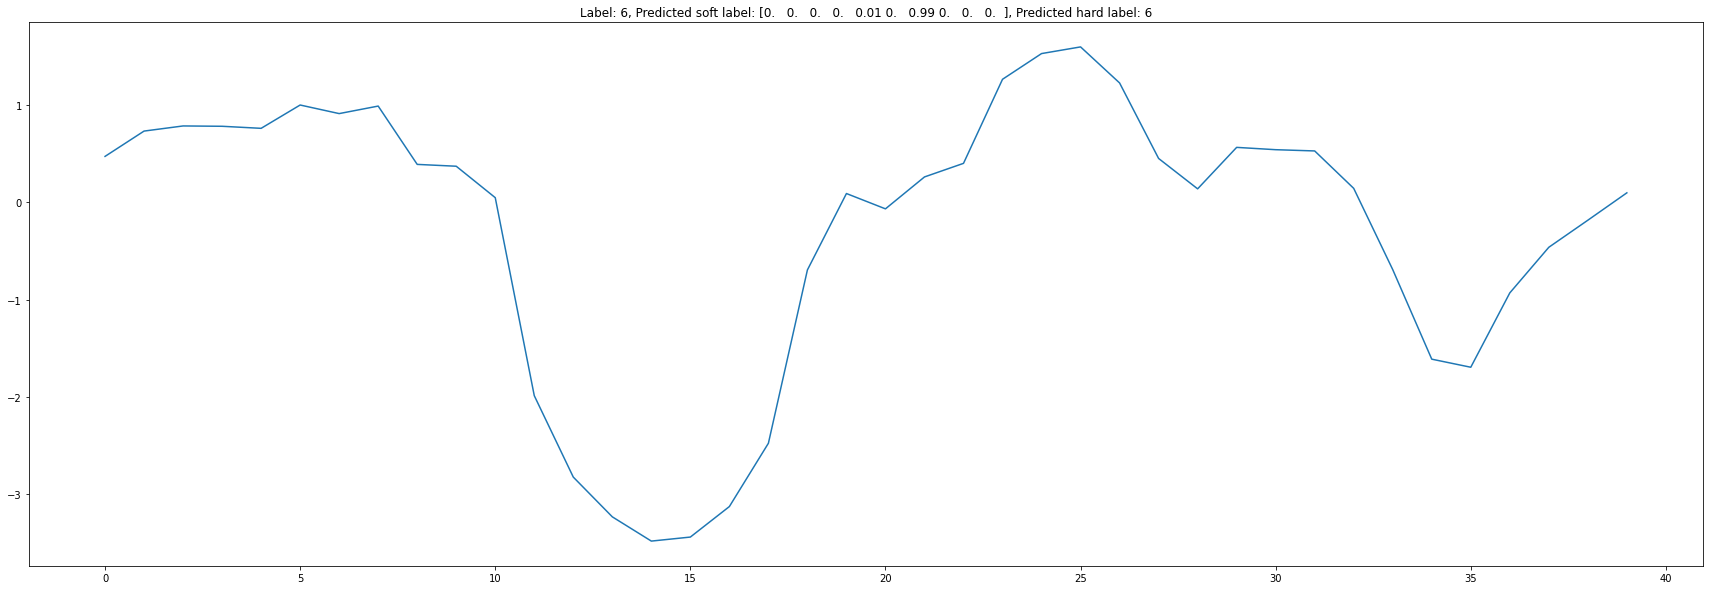

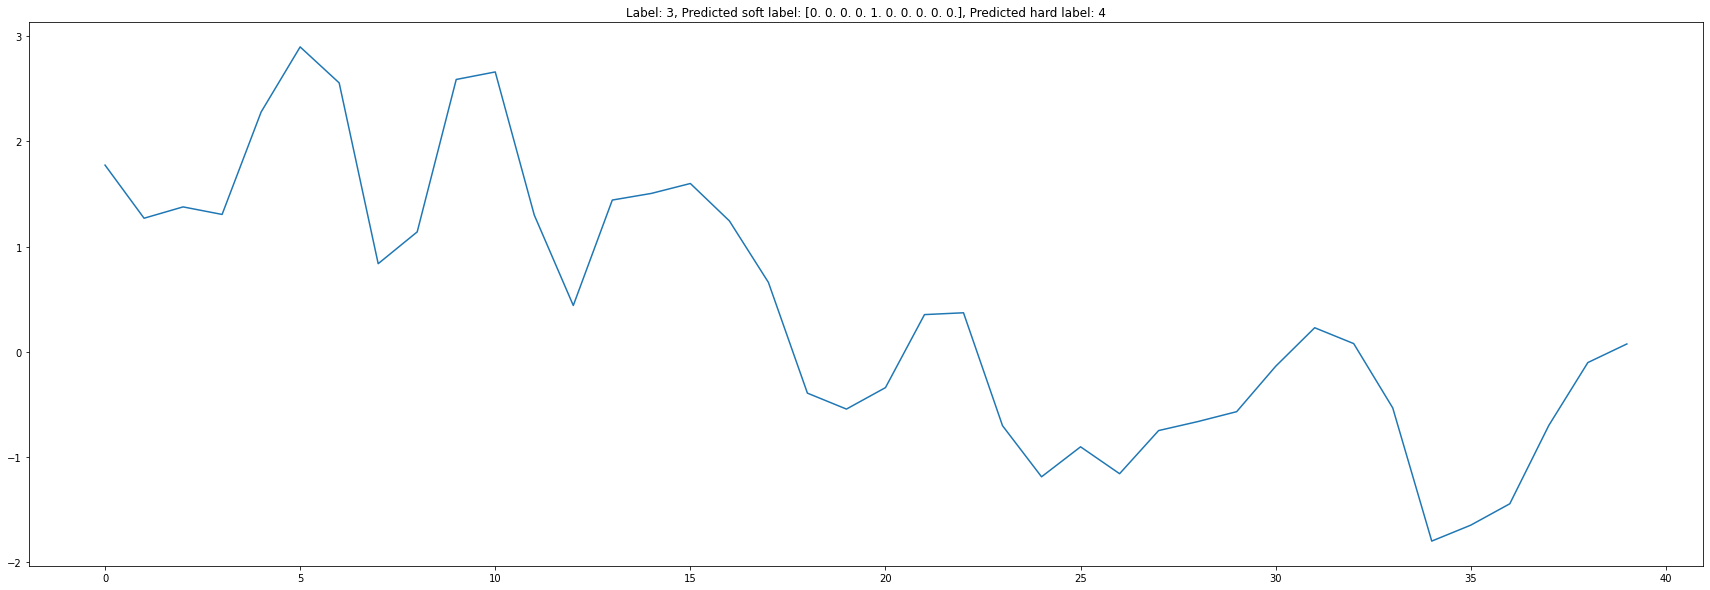

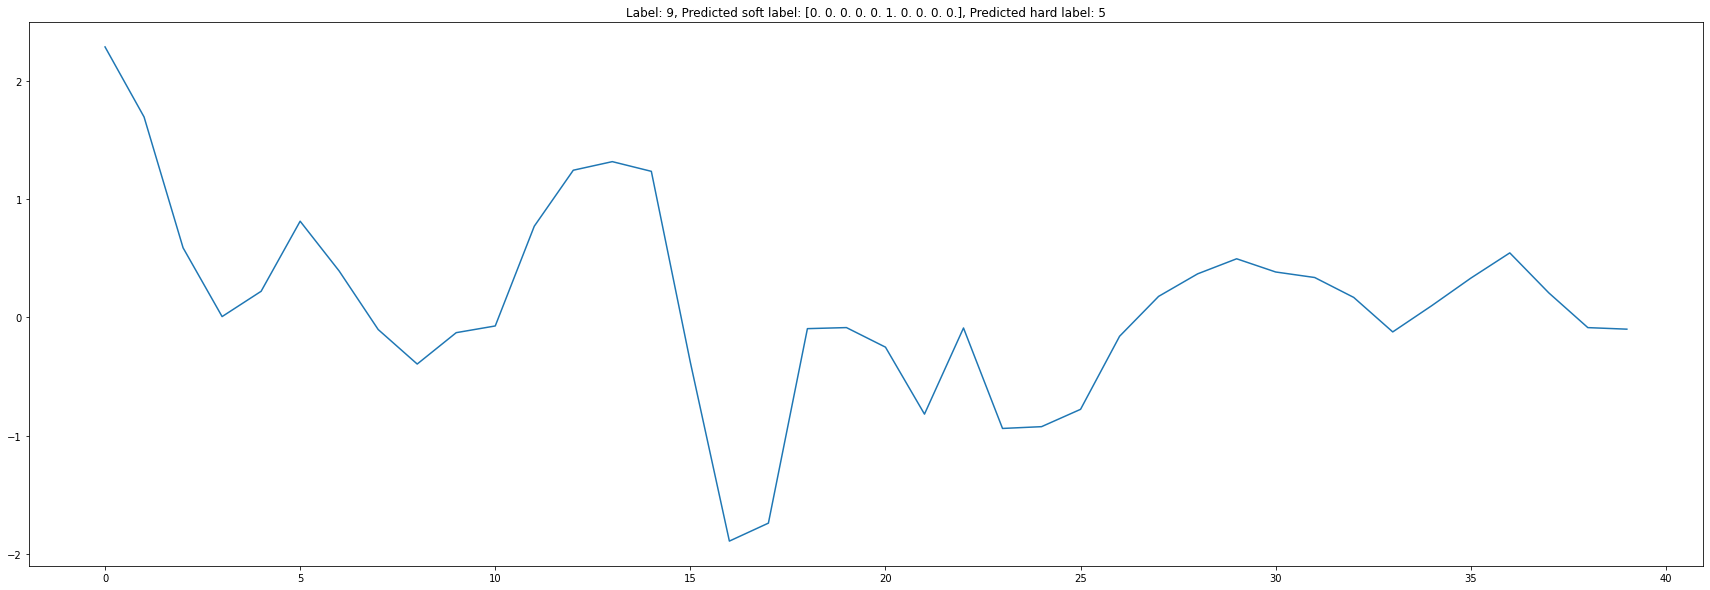

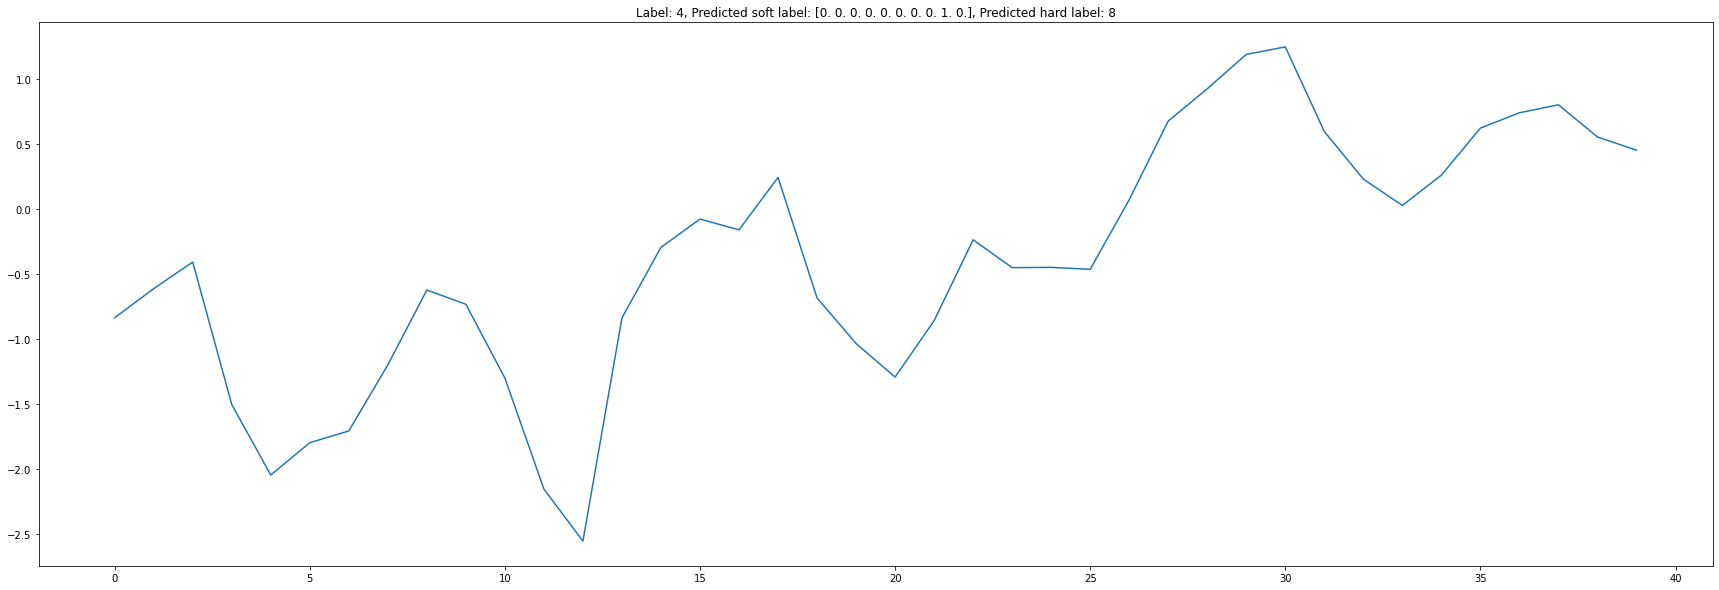

In [26]:
for i in range(x_worst.shape[0]):
    fig = plt.figure(figsize=(30,10))
    plt.plot(x_worst[i])
    plt.title(f'Label: {y_worst[i]}, Predicted soft label: {np.round(soft_pred_worst[i,:],2)}, Predicted hard label: {np.argmax(soft_pred_worst[i,:])}')
    
    

# Task 2

### SHAP (Vlad)

In [27]:
background=np.expand_dims(x_test[0:100,],axis=2) #(100, 40, 1)
explainer = shap.DeepExplainer(model, background)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


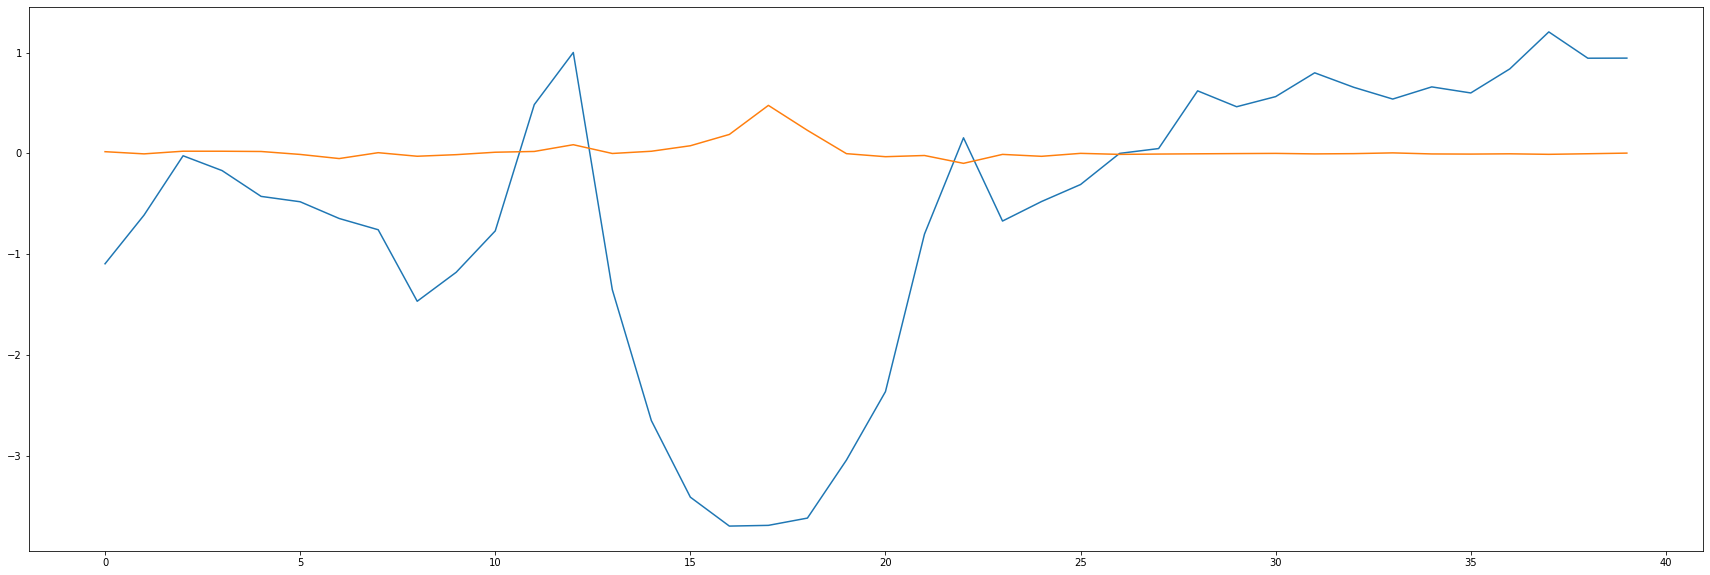

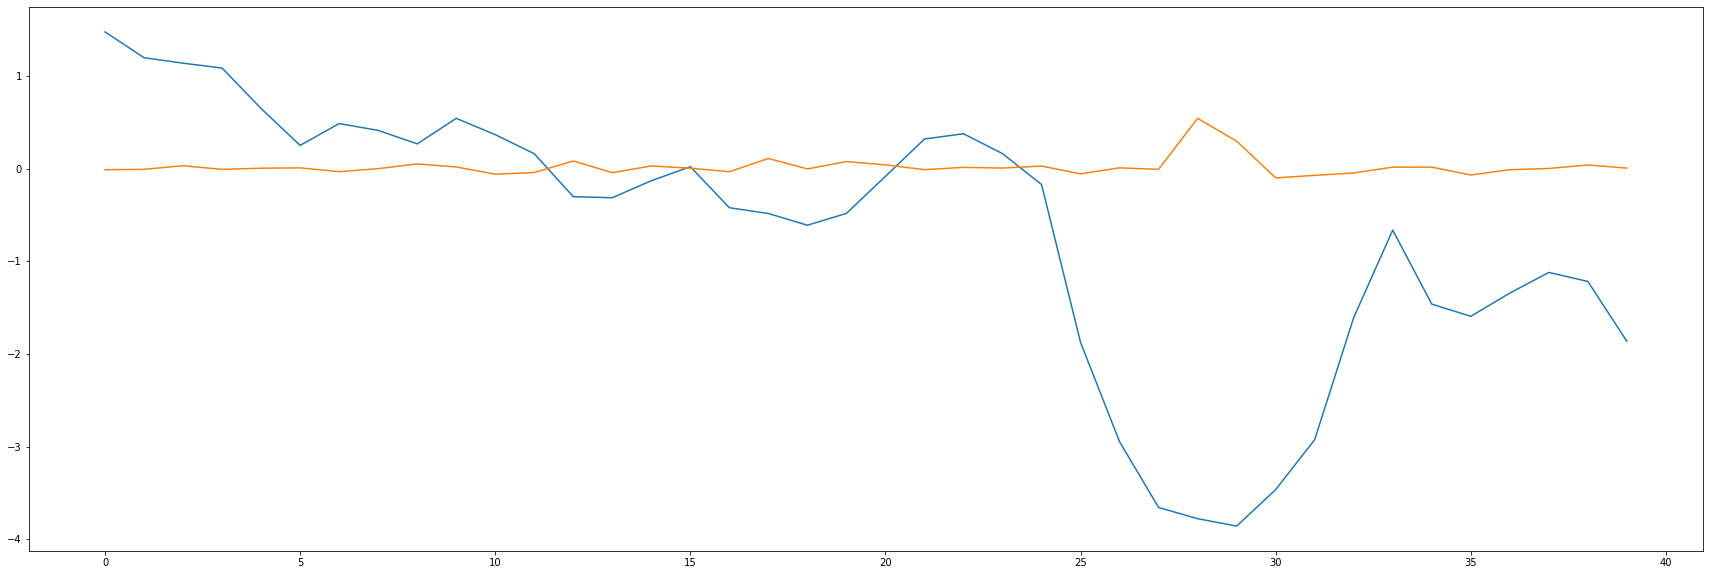

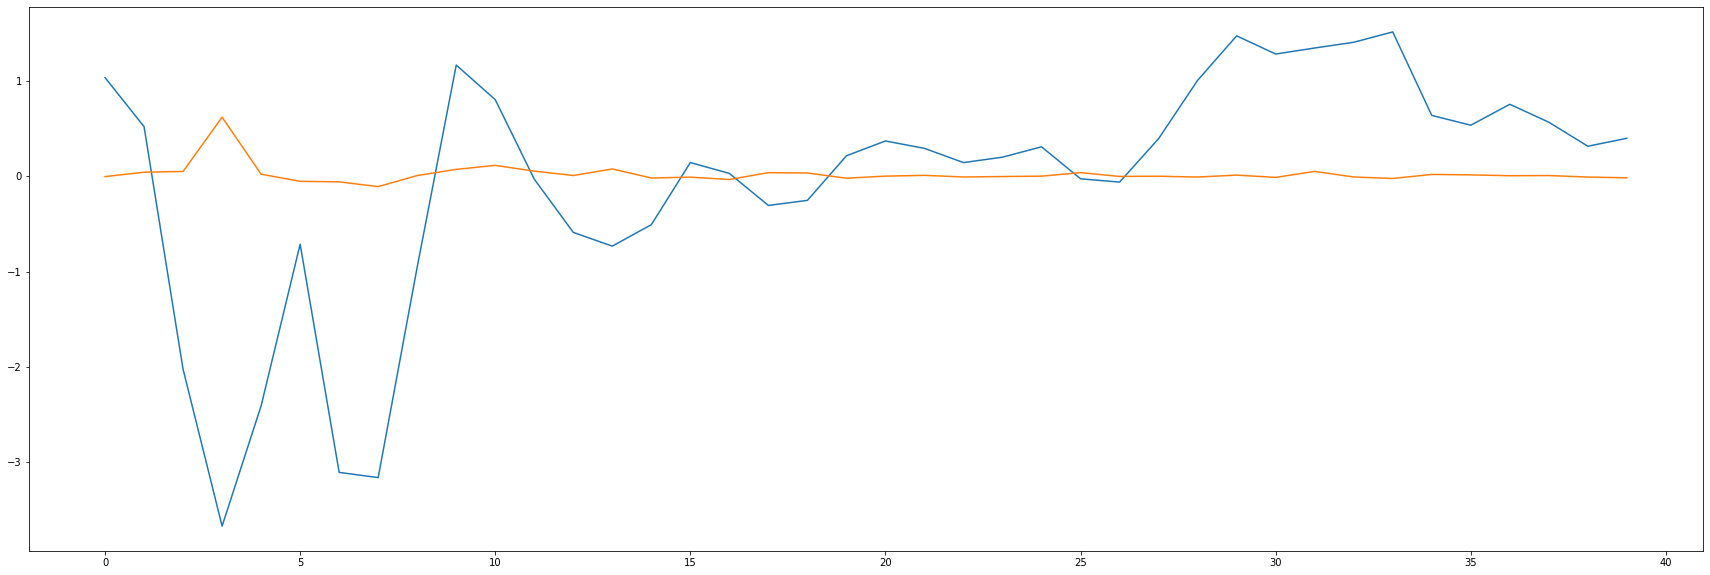

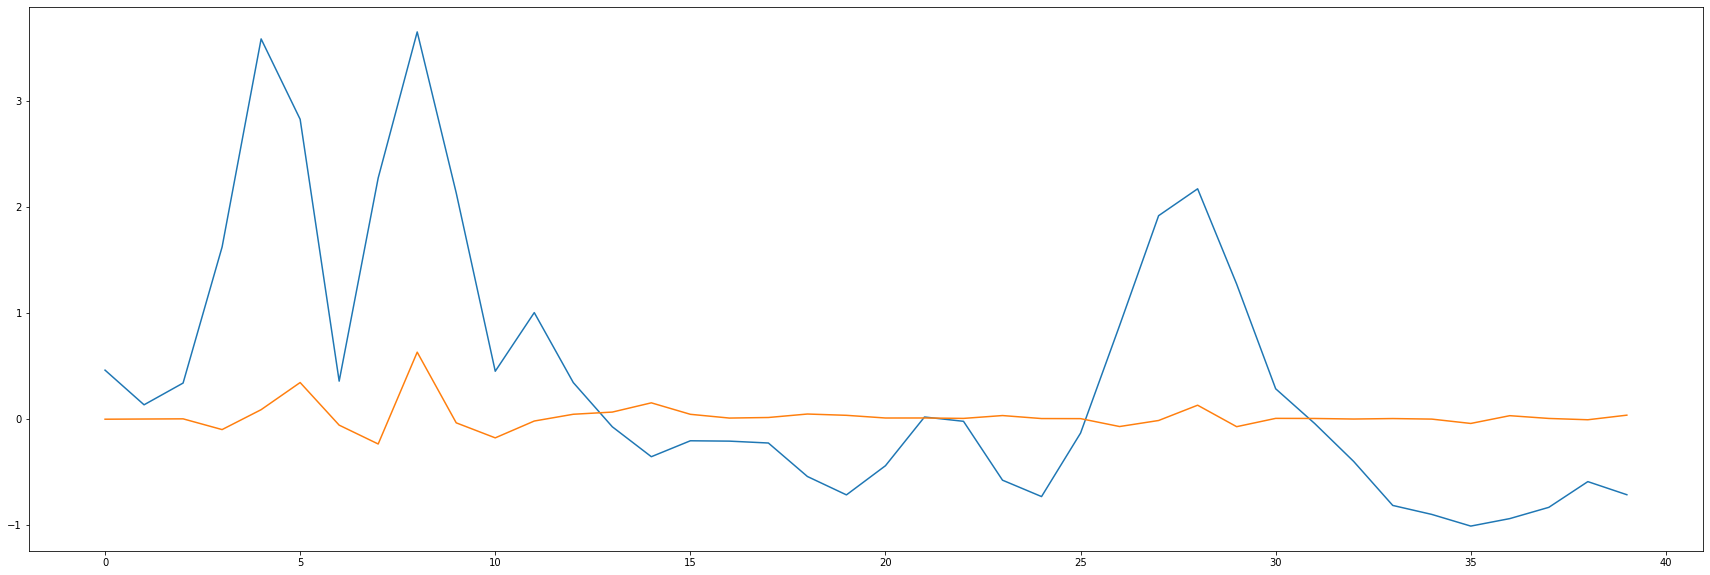

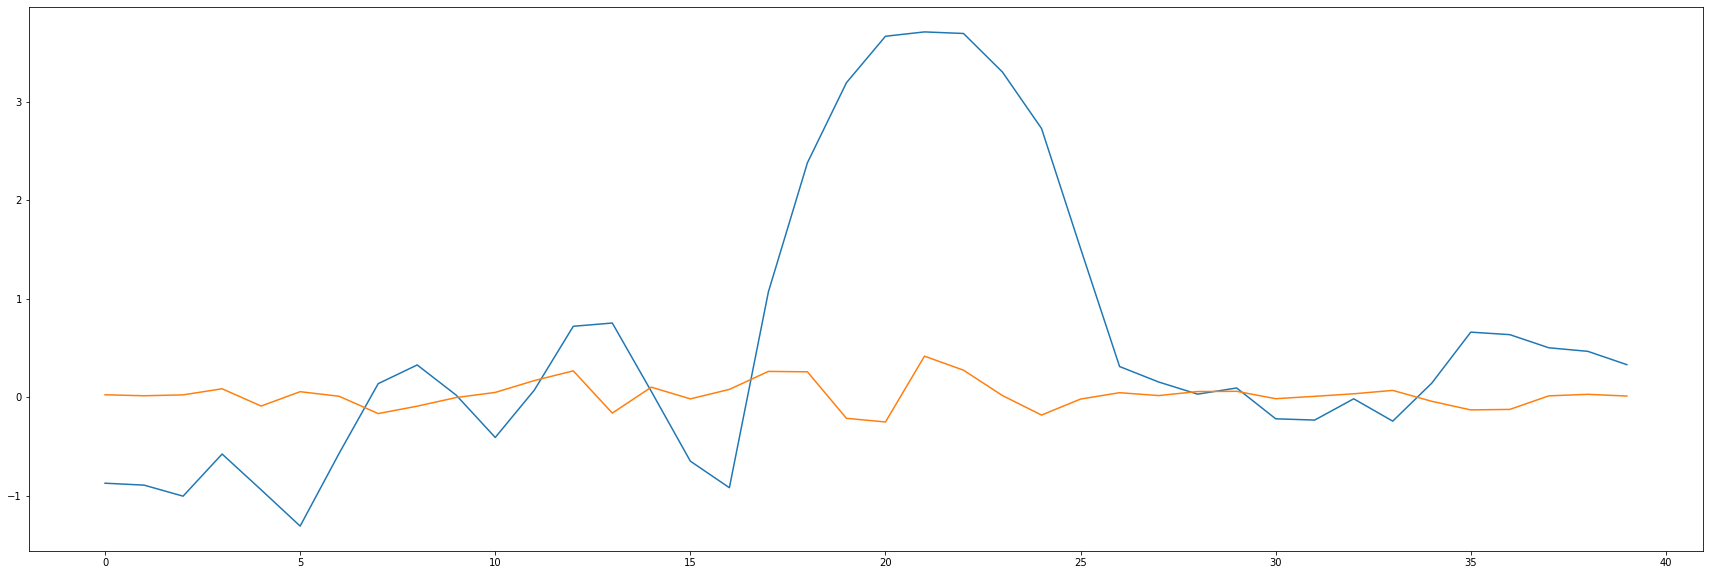

In [28]:
for i in range(x_best.shape[0]):
    besties= np.expand_dims(x_best[i:i+1],axis=2) #(1, 40, 1)
    shap_values = explainer.shap_values(besties)

    fig = plt.figure(figsize=(30,10))
    plt.plot(x_best[i])
    plt.plot(shap_values[y_best[i]][0])

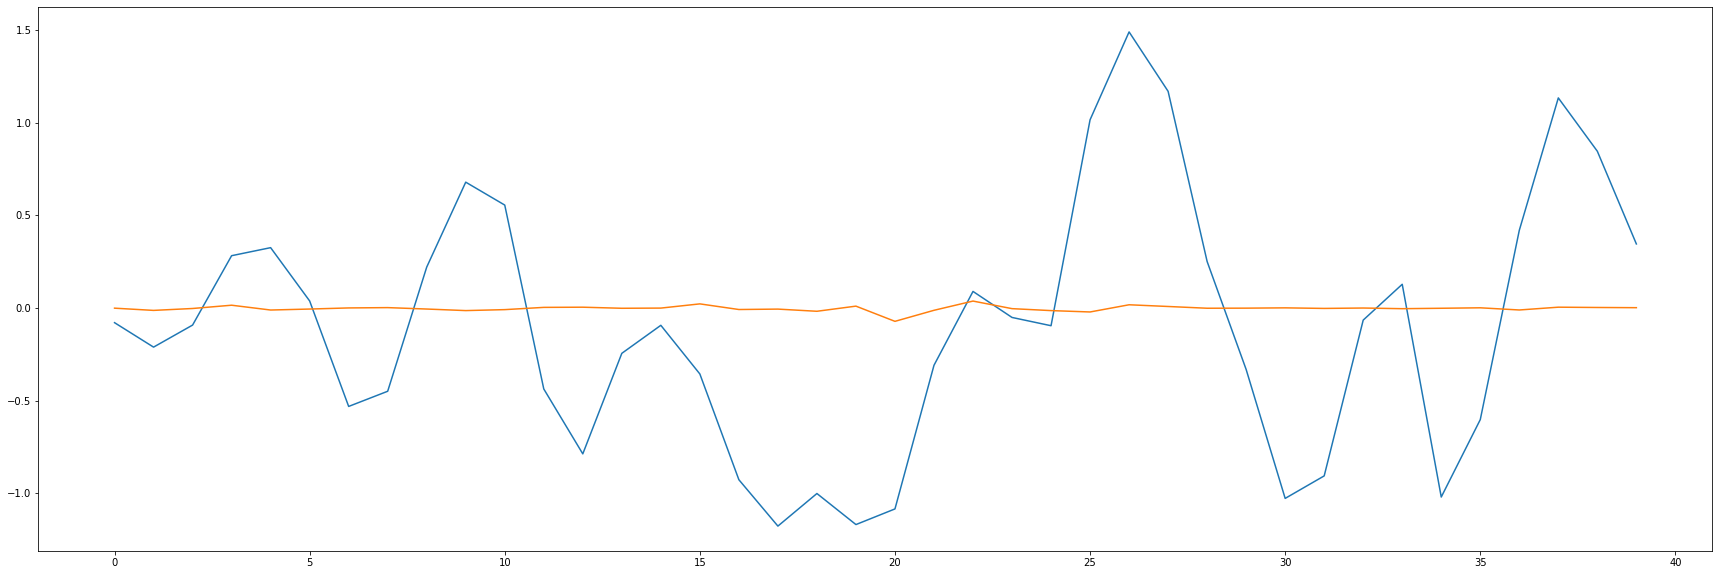

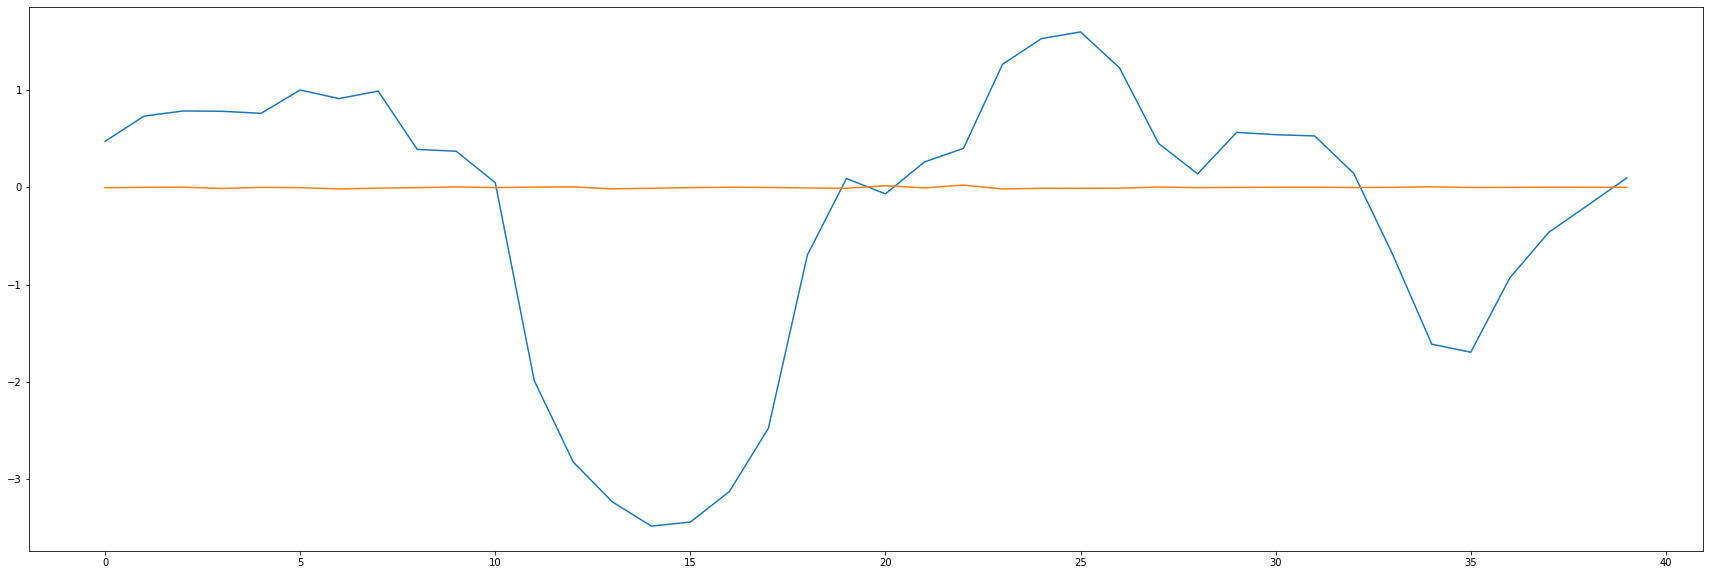

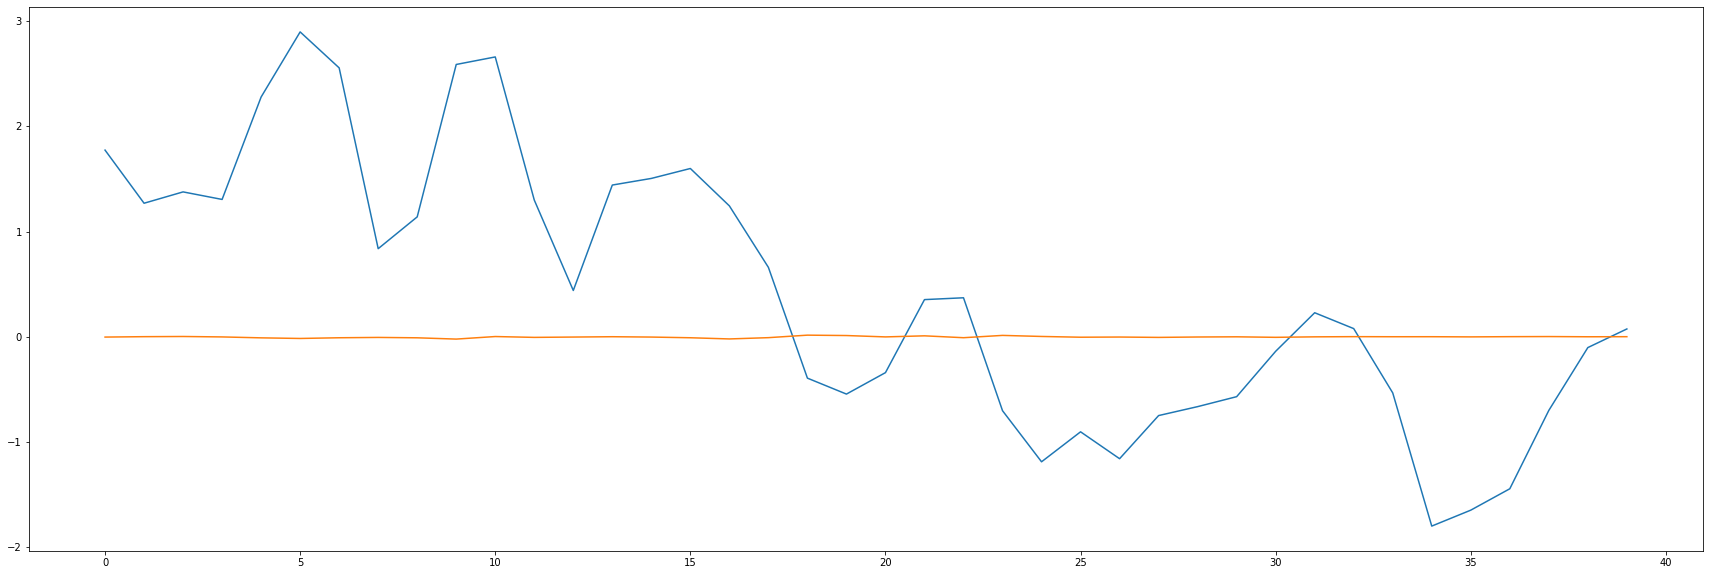

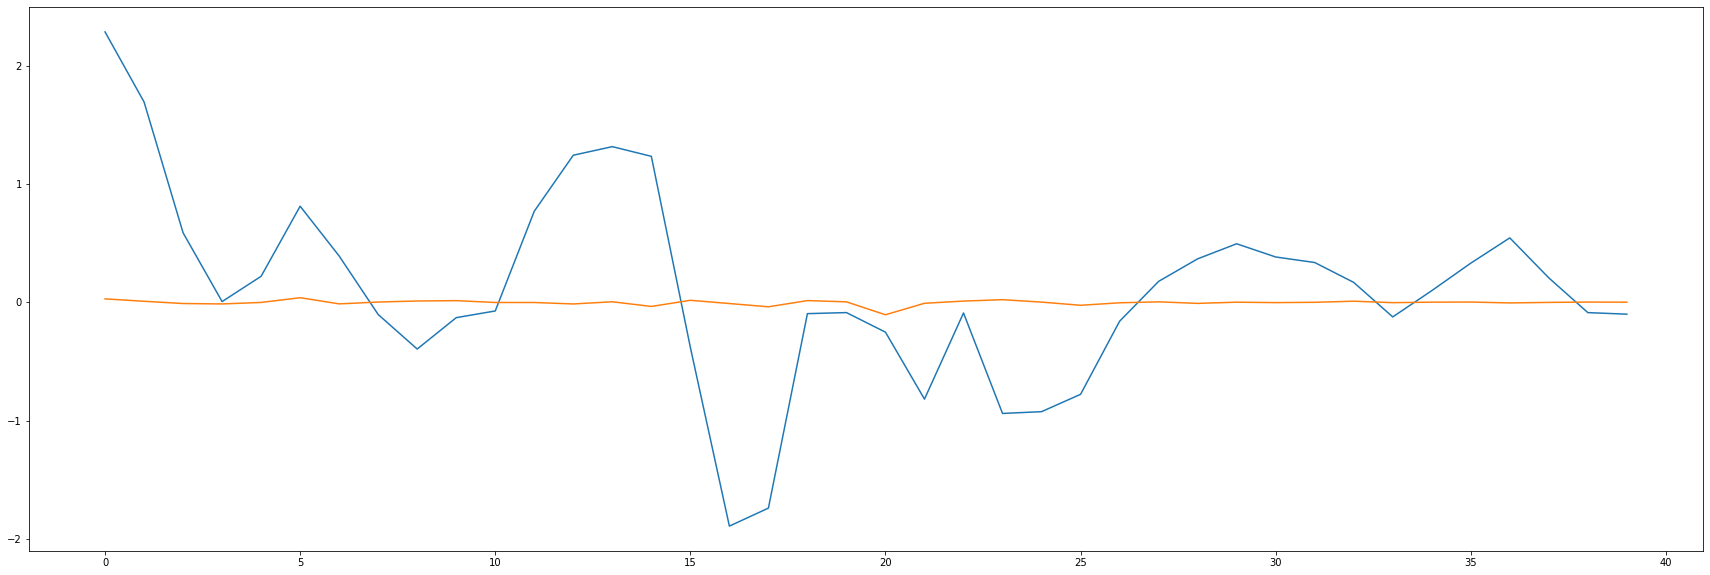

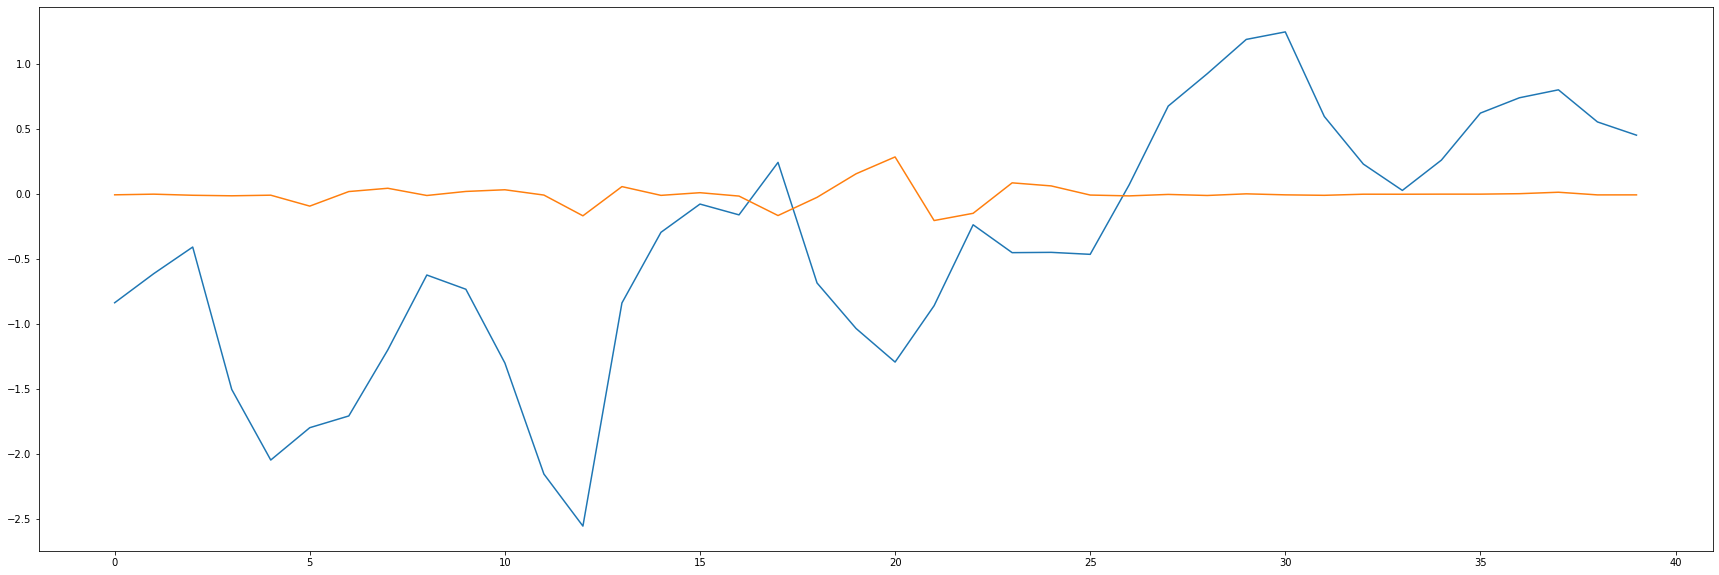

In [29]:
for i in range(x_worst.shape[0]):
    worsties= np.expand_dims(x_worst[i:i+1],axis=2) #(1, 40, 1)
    shap_values = explainer.shap_values(besties)

    fig = plt.figure(figsize=(30,10))
    plt.plot(x_worst[i])
    plt.plot(shap_values[y_worst[i]][0])

### RISE (Dmitrii)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


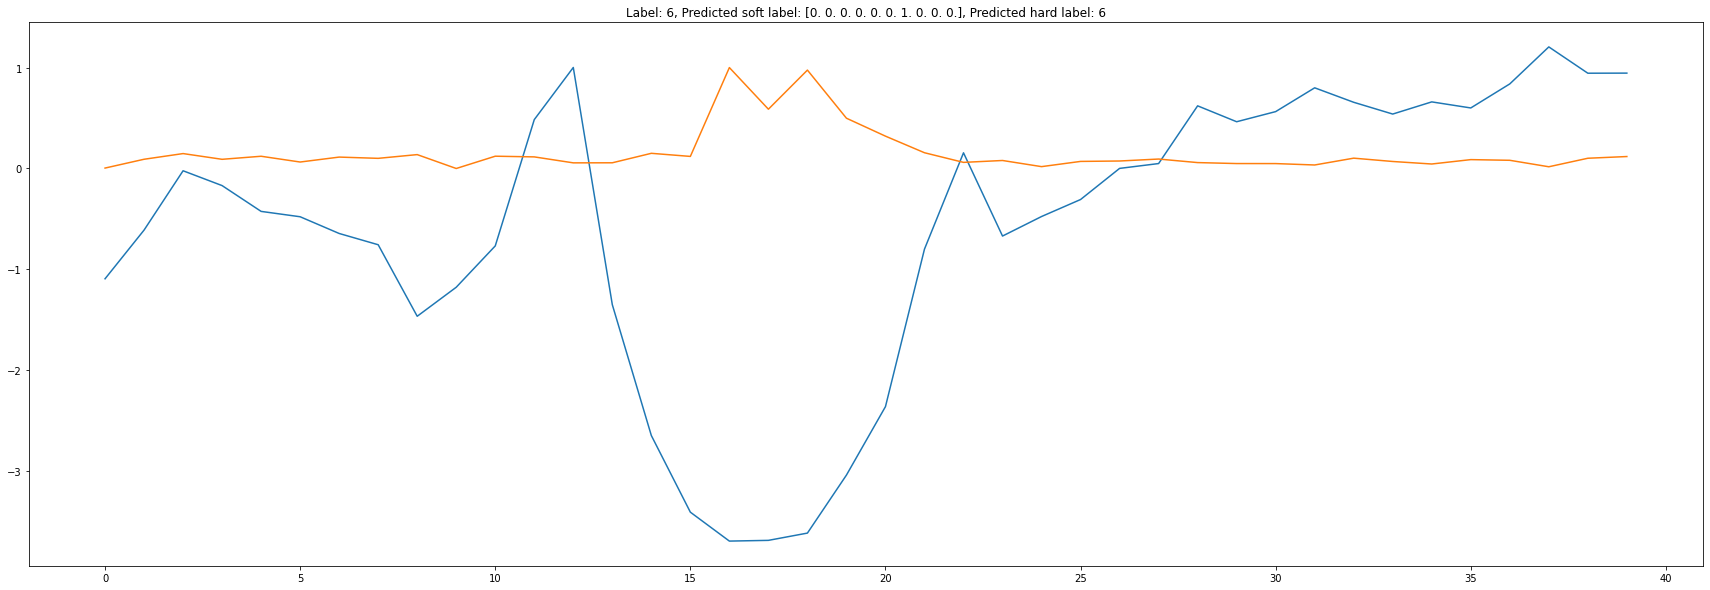

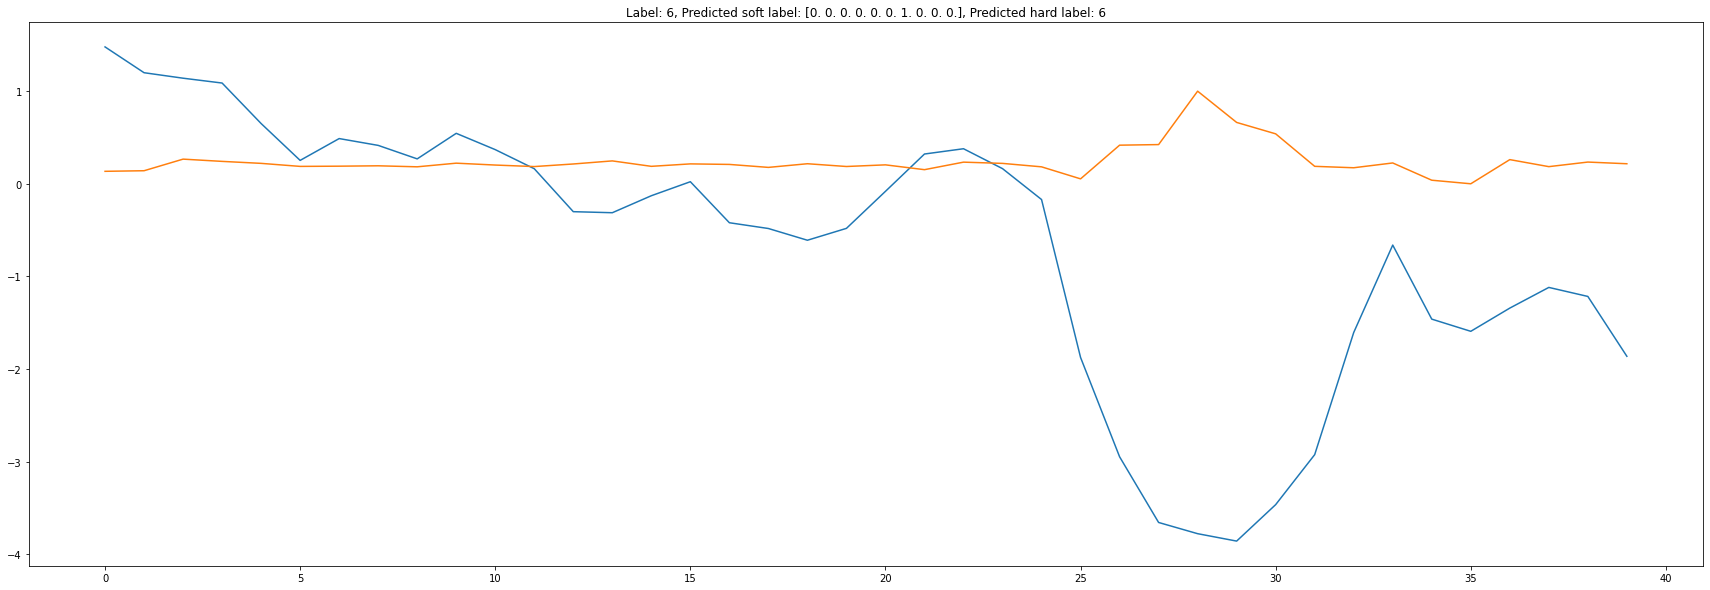

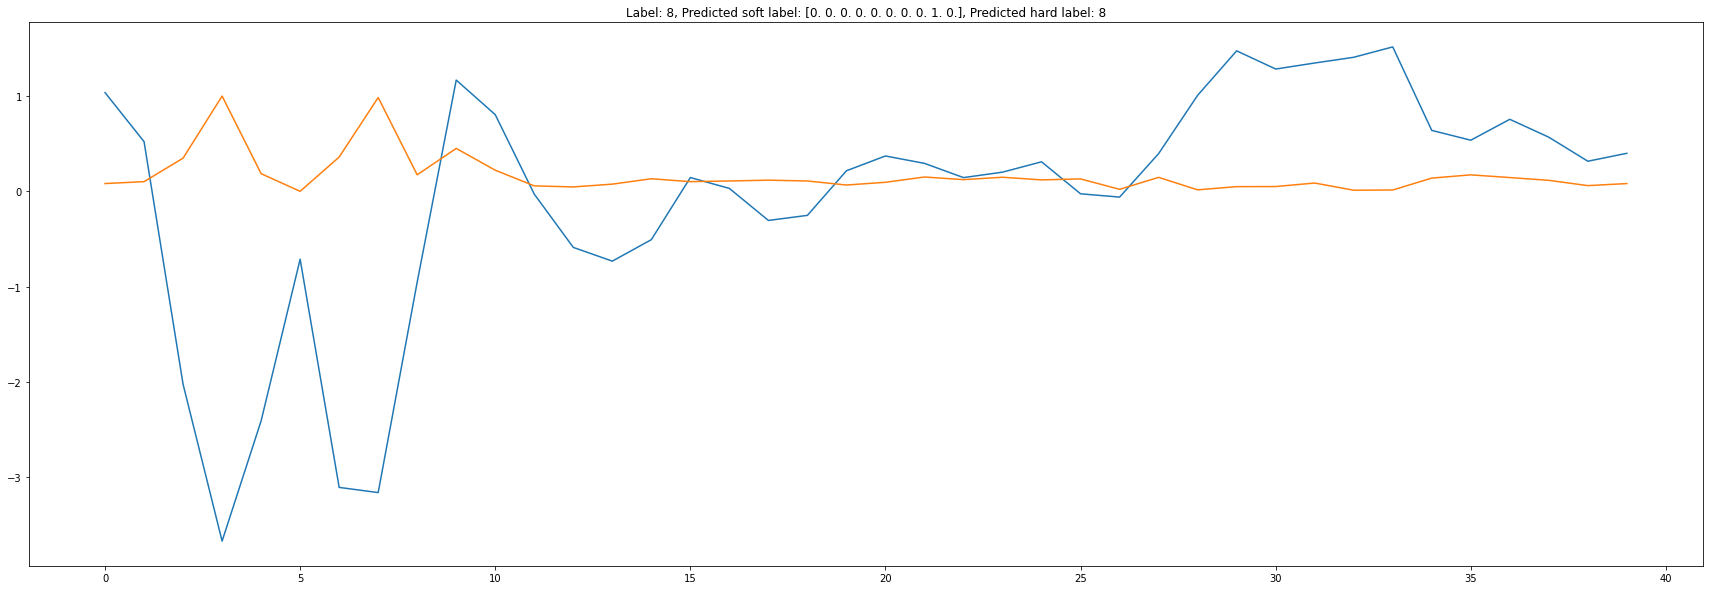

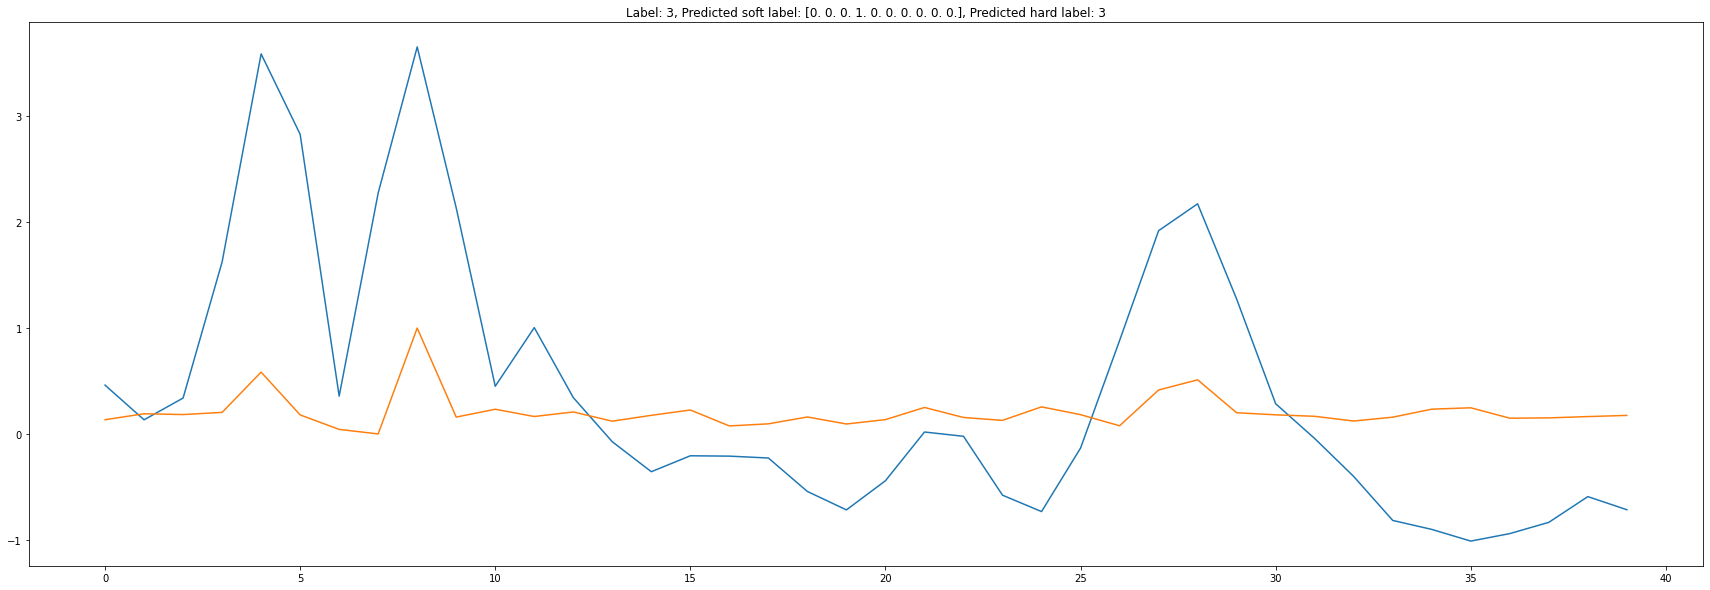

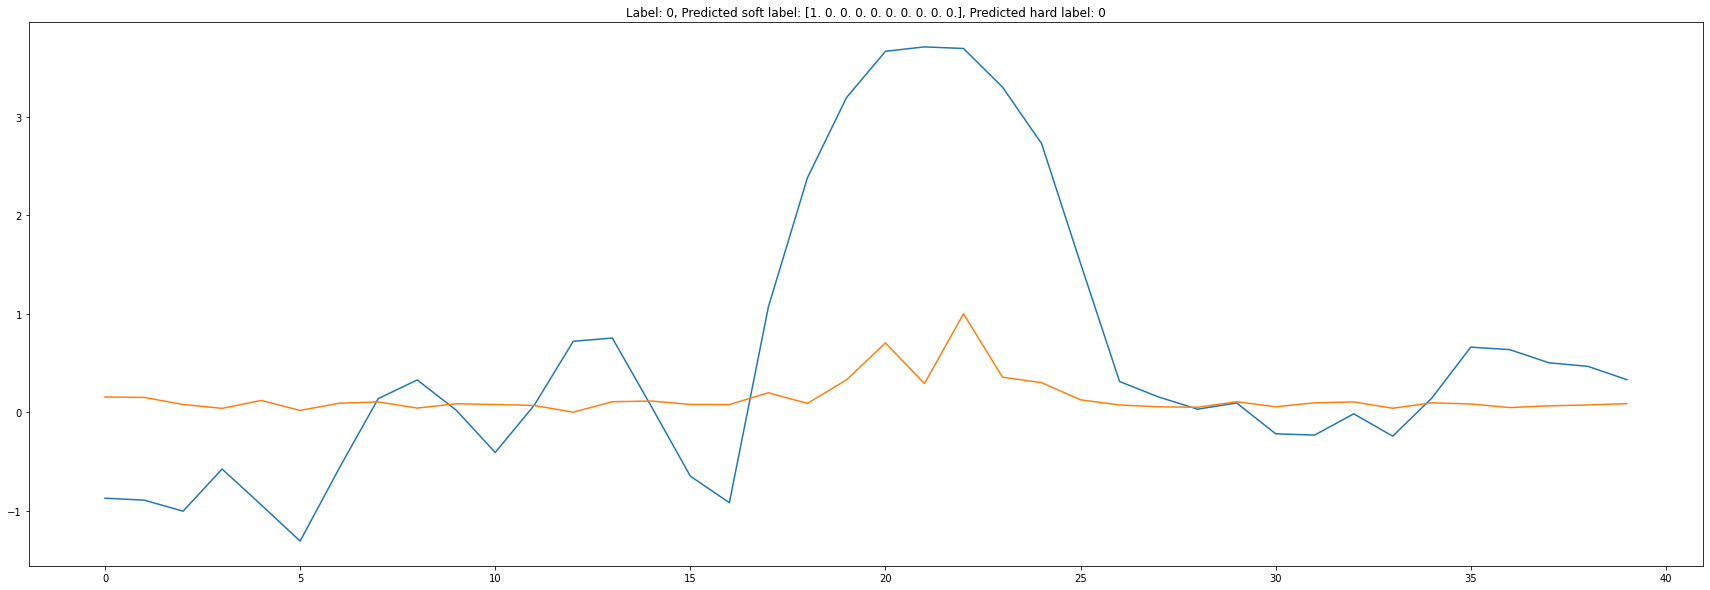

In [73]:
for i in range(x_best.shape[0]):
    
    explanation_map = RISE_1D(np.expand_dims(x_best[i:i+1],axis=2), model, y_best[i], W=40, C=1)
    
    fig = plt.figure(figsize=(30,10))
    plt.plot(x_best[i])
    plt.plot(explanation_map[:,0])
    plt.title(f'Label: {y_best[i]}, Predicted soft label: {np.round(soft_pred_best[i,:],2)}, Predicted hard label: {np.argmax(soft_pred_best[i,:])}')
    
    

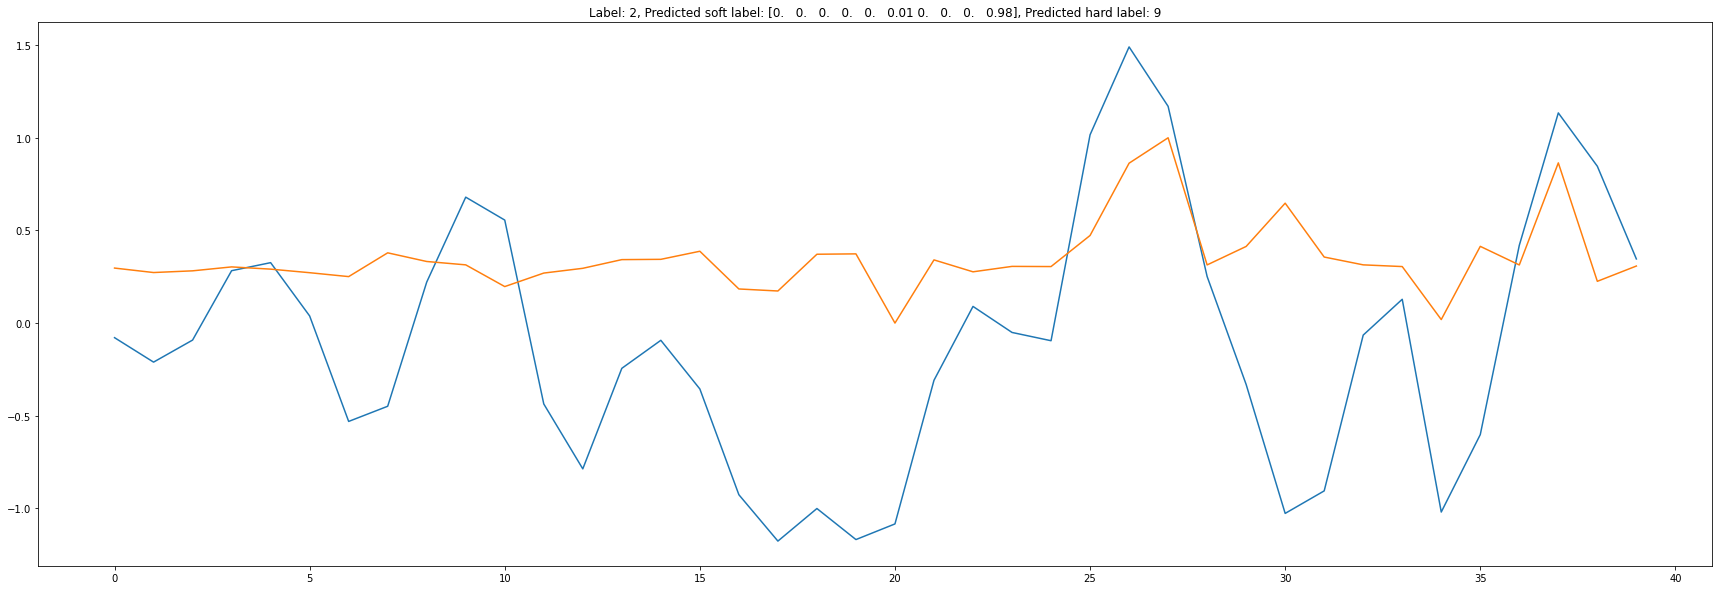

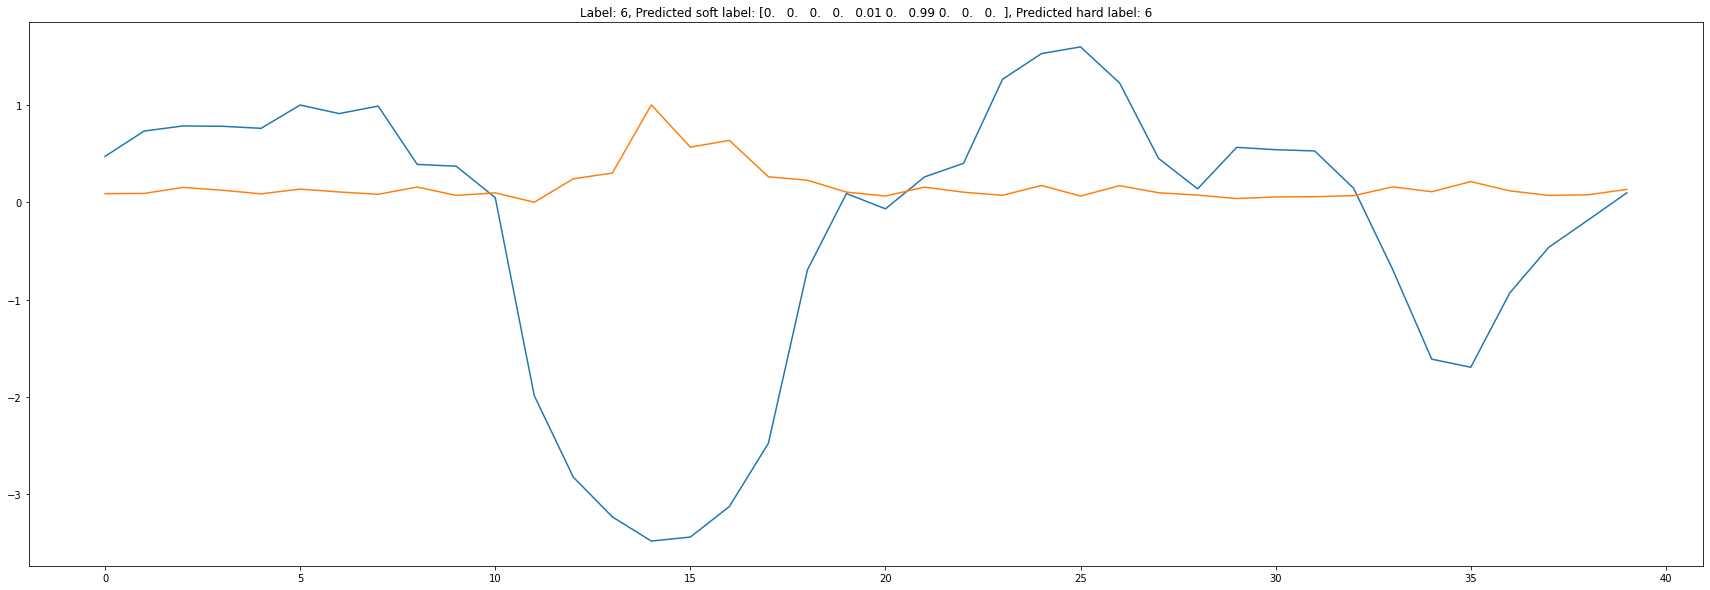

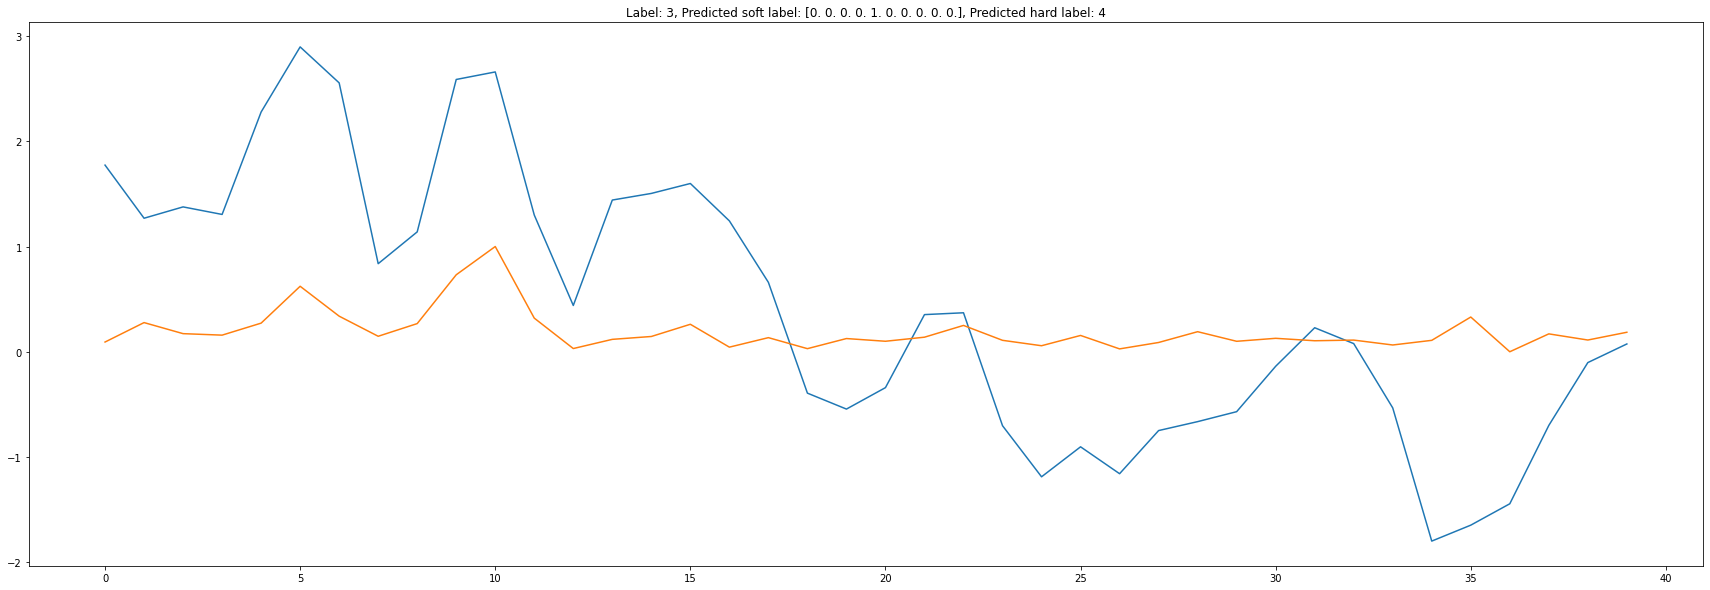

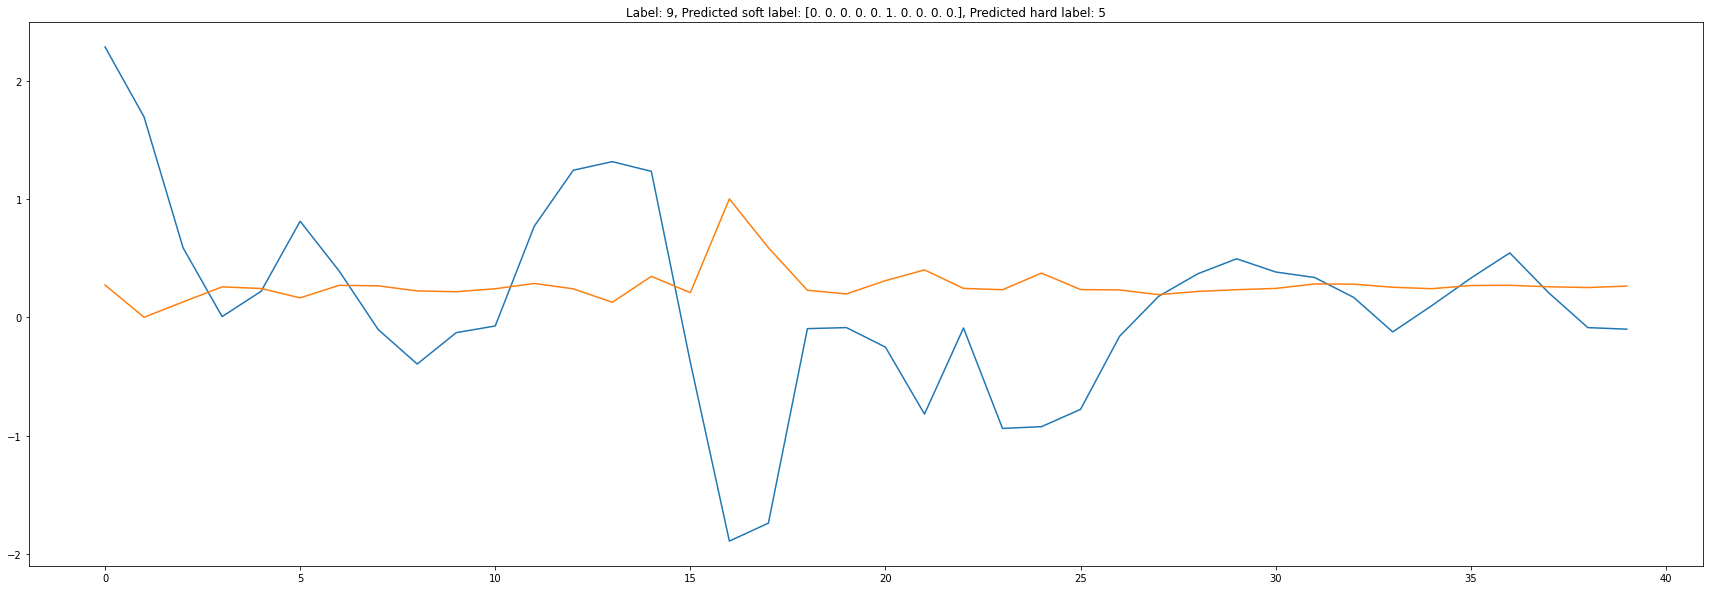

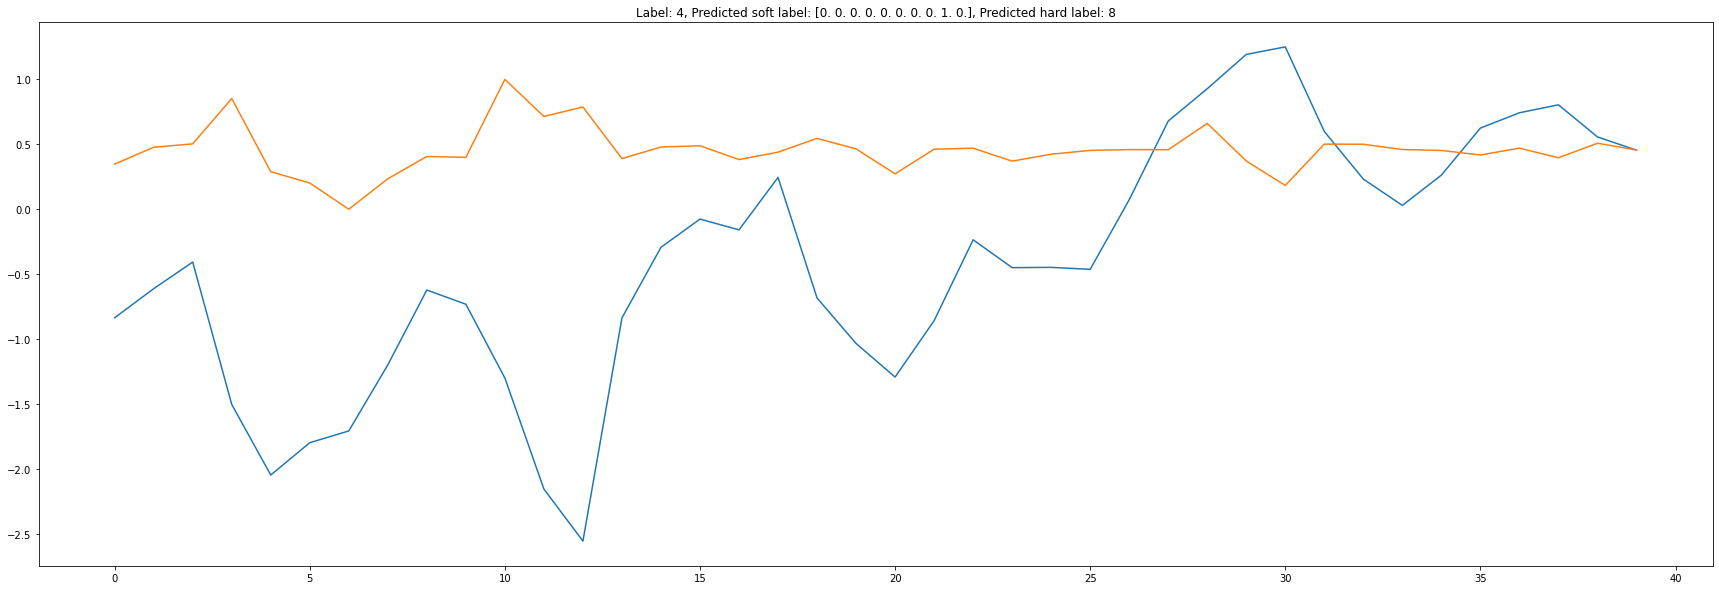

In [88]:
for i in range(x_worst.shape[0]):
    
    explanation_map = RISE_1D(np.expand_dims(x_worst[i:i+1],axis=2), model, y_worst[i], W=40, C=1)
    
    fig = plt.figure(figsize=(30,10))
    plt.plot(x_worst[i])
    plt.plot(explanation_map[:,0])
    plt.title(f'Label: {y_worst[i]}, Predicted soft label: {np.round(soft_pred_worst[i,:],2)}, Predicted hard label: {np.argmax(soft_pred_worst[i,:])}')

# Task 4 

In [ ]:
for i in range(x_worst.shape[0]):
    
    explanation_map = RISE_1D(np.expand_dims(x_worst[i:i+1],axis=2), model, y_worst[i], W=40, C=1)
    
    fig = plt.figure(figsize=(30,10))
    plt.plot(x_worst[i])
    plt.plot(explanation_map[:,0])
    plt.title(f'Label: {y_worst[i]}, Predicted soft label: {np.round(soft_pred_worst[i,:],2)}, Predicted hard label: {np.argmax(soft_pred_worst[i,:])}')